# General aspects

In this section we will discuss a number of issues and questions relating to core spectroscopies, ranging from the physical effect of a core-transitions, to technical aspects relating to lowering computational costs. Thew are ordered by approximate relevance, with some topics being pertient only for certain cases.

*Loading modules and functions:*

In [1]:
# standard Python modules and functions
from scipy.interpolate import interp1d
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
import copy

# QC software suites and functionalities
from pyscf import gto, scf, mp, cc
import veloxchem as vlx
import gator
import adcc
from veloxchem.rsplinabscross import LinearAbsorptionCrossSection

# for vlx
silent_ostream = vlx.OutputStream(None)
from mpi4py import MPI
comm = MPI.COMM_WORLD

# au to eV conversion factor
au2ev = 27.211386

# Lorentzian broadening function
#   called with [energies, intensities, start energy, end energy, energy step, gamma]
def lorentzian(x, y, xmin, xmax, xstep, gamma):
    xi = np.arange(xmin,xmax,xstep); yi=np.zeros(len(xi))
    for i in range(len(xi)):
        for k in range(len(x)): yi[i] = yi[i] + y[k] * (gamma/2.) / ( (xi[i]-x[k])**2 + (gamma/2.)**2 )
    return xi,yi

* Warning * Environment variable OMP_NUM_THREADS not set.
* Warning * Setting OMP_NUM_THREADS to 4.


(sec:xray_topics_relax)=
## Relaxation

Core spectroscopies exhibit strong relaxation effects, originating in the significant change in shielding of the nuclear charge arising from the creation/annihilation of a core-hole. These effects need to be properly accounted for in order to get good absolute energies, as  the lack of this will mean that, *e.g.* an unrelaxed core-hole system is too high in energy. This explains the previously observed large error obtained from Koopmans' theorem.

### Relaxation of core-ionized systems

In {numref}`relax_form` we see the effects of relaxation for creating a core-hole in the oxygen/carbon 1s of formaldehyde:

```{figure} ../img/xray/relax_form.svg
---
name: relax_form
---
The total electron density of formaldehyde, featuring the neutral system and core-ionized at the carbon and oxygen 1s.
```

We see that there are noticable attraction of electron density toward the core-holes, which is particularly visible when viewed from the side. These effects can be modeled with the $Z+1$ approximation, within which the change in screening is modeled by substituting the ionized atom with the next element in the periodic table. This can be illustrated with the following radial distribution plot:

In [22]:
water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""
water_fluorine_xyz = """
F       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""

### Neutral and core-hole water
# Create pyscf mol object
mol       = gto.Mole()
mol.atom  = water_xyz
mol.basis = 'unc-6-31G'
mol.build()
# Perform unrestricted SCF calculation
scf_gs = scf.UHF(mol)
scf_gs.kernel()
# Copy molecular orbitals
mo0  = copy.deepcopy(scf_gs.mo_coeff)
occ0 = copy.deepcopy(scf_gs.mo_occ)
# Create 1s core-hole by setting beta_0 population to zero
occ0[1][0] = 0.0   
# Perform unrestricted SCF calculation with MOM constraint
scf_ion = scf.UHF(mol)
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()

### Fluorine-substituted water
# Create pyscf mol object
mol_fl        = gto.Mole()
mol_fl.atom   = water_fluorine_xyz
mol_fl.basis  = 'unc-6-31G'
mol_fl.charge = 1 # Closed-shell
mol_fl.build()
# Perform unrestricted SCF calculation
scf_gs_fl = scf.UHF(mol_fl)
scf_gs_fl.kernel()

Ay = 0.0                      # oxygen y-position (in au)
Az = 0.1178336003/0.529177249 # oxygen z-position (in au)

# Create coordinate object along x-axis (intersecting with O/F atom)
coords = []
for ix in np.arange(-4, 4, 0.001):
    coords.append((ix,Ay,Az))
coords = np.array(coords)

# AO values and MO values on given grids
# Neutral water
ao_gs  = mol.eval_gto('GTOval_sph', coords)
mo_gs  = ao_gs.dot(scf_gs.mo_coeff)

# Water core-hole
ao_ion = mol.eval_gto('GTOval_sph', coords)
mo_ion = ao_ion.dot(scf_ion.mo_coeff)

# Z+1
ao_Z1  = mol_fl.eval_gto('GTOval_sph', coords)
mo_Z1  = ao_Z1.dot(scf_gs_fl.mo_coeff)

converged SCF energy = -75.9890271783204  <S^2> = 8.9093177e-12  2S+1 = 1
converged SCF energy = -56.1707263747173  <S^2> = 0.76785153  2S+1 = 2.0177726
converged SCF energy = -100.169768736219  <S^2> = 4.3254289e-13  2S+1 = 1


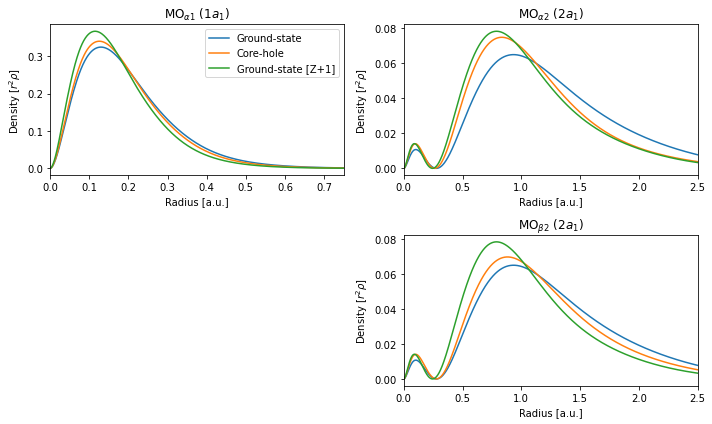

In [20]:
plt.figure(figsize=(10,6))
plt.subplot(221); plt.title(r'MO$_{\alpha 1}$ ($1a_1$)')
mo_nr = 0
r,rho1,rho2,rho3 = [],[],[],[]
for i in np.arange(len(coords)):
        r.append(coords[i][0])
        rho1.append(coords[i][0]**2*mo_gs[i][0][mo_nr]**2)
        rho2.append(coords[i][0]**2*mo_ion[i][0][mo_nr]**2)
        rho3.append(coords[i][0]**2*mo_Z1[i][0][mo_nr]**2)
plt.plot(r,rho1); plt.plot(r,rho2); plt.plot(r,rho3)
plt.legend(('Ground-state','Core-hole','Ground-state [Z+1]'))
plt.xlim((0,0.75)); plt.xlabel('Radius [a.u.]'); plt.ylabel(r'Density [$r^2 \rho$]')

plt.subplot(222); plt.title(r'MO$_{\alpha 2}$ ($2a_1$)')
mo_nr = 1
r,rho1,rho2,rho3 = [],[],[],[]
for i in np.arange(len(coords)):
        r.append(coords[i][0])
        rho1.append(coords[i][0]**2*mo_gs[i][0][mo_nr]**2)
        rho2.append(coords[i][0]**2*mo_ion[i][0][mo_nr]**2)
        rho3.append(coords[i][0]**2*mo_Z1[i][0][mo_nr]**2)
plt.plot(r,rho1); plt.plot(r,rho2); plt.plot(r,rho3)
plt.xlim((0,2.5)); plt.xlabel('Radius [a.u.]'); plt.ylabel(r'Density [$r^2 \rho$]')

plt.subplot(224); plt.title(r'MO$_{\beta 2}$ ($2a_1$)')
mo_nr = 1
r,rho1,rho2,rho3 = [],[],[],[]
for i in np.arange(len(coords)):
        r.append(coords[i][0])
        rho1.append(coords[i][0]**2*mo_gs[i][1][mo_nr]**2)
        rho2.append(coords[i][0]**2*mo_ion[i][1][mo_nr]**2)
        rho3.append(coords[i][0]**2*mo_Z1[i][1][mo_nr]**2)
plt.plot(r,rho1); plt.plot(r,rho2); plt.plot(r,rho3)
plt.xlim((0,2.5)); plt.xlabel('Radius [a.u.]'); plt.ylabel(r'Density [$r^2 \rho$]')

plt.tight_layout(); plt.show()

As can be seen, the radial distribution of particularly $\alpha_2$ for the core-ionized system is closer to $Z+1$ than to the neutral state, although this agreement is lower for $\alpha_1$ and $\beta_2$. Also note the different x-scales.


### Relaxation of core-excitation or de-excitation

For X-ray absorption and emission spectroscopy the influence of the relaxation is partially the opposite, with

- Relaxation in XAS leading to a more contracted final state, which lower absorption energies

- Relaxation in XES leading to a more decontracted final state, which increase emission energies

In addition to these strong changes in shielding, there are also additional couplings due to the population of a previous unoccupied stat (XAS) or the creation of a valence-hole (XES). These effects are smaller and partially counteract the stronger change due to change in shielding, leading to a total picture as follows:

```{figure} ../img/xray/relax_processes.svg
---
name: relax_processes
---
Relaxation effects involved in X-ray absorption (left) and emission (right) spectroscopies. Showing which orbitals primarily contribute to the respective effects, as well as the result in MO energ (or electron density).
```

We here see the four main total effects:

- X-ray absorption spectroscopy

    1. A strong relaxation effect due to the creation of a core-hole, which leads to contraction of electron density and scales with element
    
    2. A weak polarization effect due to coupling with the newly occupied valence state, which partially decontracts the outer valence density and does not scale appreciably with the element
    
- X-ray emission spectroscopy

    1. A strong repulsion effect due to the annihilation of a core-hole, which leads to decontraction of electron density and scales with element
    
    2. A weaker outer relaxation effect due to the creation of a valence-hole, which leads to contraction of the (outer) valence density and scales with element

These effects balances in different manners, and the exact strength depends heavily on the element and which edge is being probed. As such, the accuracy of a particular scheme (*e.g.* ADC) depends on which spectroscopy, element, and edge is considered.


### Including with $\Delta$SCF methods

$\Delta$SCF methods provide the most direct way of including relaxation, as the core-hole state is explicitly optimized. However, this approach need to consider each transition explicitly, and will have difficulties in calculating both the transition moment and in properly converging higher excited states. As such, it is mainly useful for considering ionization potentials and for providing a reference state for XES calculations. Comparing the performance of IP:s from Koopmans' theorem and $\Delta$SCF:

In [18]:
methane_xyz = """
C       0.0000000000     0.0000000000     0.0000000000
H       0.6265918120     0.6265918120     0.6265918120
H      -0.6265918120    -0.6265918120     0.6265918120
H      -0.6265918120     0.6265918120    -0.6265918120
H       0.6265918120    -0.6265918120    -0.6265918120
"""
ammonia_xyz = """
N       0.0000000000     0.0000000000     0.1175868000
H       0.9323800000     0.0000000000    -0.2743692000
H      -0.4661900000    -0.8074647660    -0.2743692000
H      -0.4661900000     0.8074647660    -0.2743692000
"""
water_xyz = """
O       0.0000000000     0.0000000000     0.1178336003
H      -0.7595754146    -0.0000000000    -0.4713344012
H       0.7595754146     0.0000000000    -0.4713344012
"""
hydrofluoride_xyz = """
H       0.0000000000     0.0000000000    -0.8261856000
F       0.0000000000     0.0000000000     0.0917984000
"""
neon_xyz = """
Ne      0.0000000000     0.0000000000     0.0000000000
"""

def Koopman_vs_delta(molecule, basis, ecp = None):
    # Create pyscf mol object
    mol       = gto.Mole()
    mol.atom  = molecule
    mol.basis = basis
    if ecp: # optional ECP - to be used later
        mol.ecp = ecp
    mol.build()
    # Perform unrestricted SCF calculation
    scf_gs = scf.UHF(mol)
    scf_gs.kernel()
    # Copy molecular orbitals
    mo0  = copy.deepcopy(scf_gs.mo_coeff)
    occ0 = copy.deepcopy(scf_gs.mo_occ)
    # Create 1s core-hole by setting alpha_0 population to zero
    occ0[0][0] = 0.0
    # Perform unrestricted SCF calculation with MOM constraint
    scf_ion = scf.UHF(mol)
    scf.addons.mom_occ(scf_ion, mo0, occ0)
    scf_ion.kernel()
    # Return MO energy and deltaSCF
    return -au2ev*scf_gs.mo_energy[0][0],au2ev*(scf_ion.energy_tot() - scf_gs.energy_tot())

# Basis set and container for errors
basis = 'unc-6-31G'
err_koopman, err_delta = [],[]

expt, rel = 290.76, 0.11 # experimental IP and scalar-relativistic effects
E_Koopman, E_delta = Koopman_vs_delta(methane_xyz, basis)
err_koopman.append(E_Koopman+rel-expt); err_delta.append(E_delta+rel-expt)

expt, rel = 405.52, 0.21 # experimental IP and scalar-relativistic effects
E_Koopman, E_delta =Koopman_vs_delta(ammonia_xyz, basis)
err_koopman.append(E_Koopman+rel-expt); err_delta.append(E_delta+rel-expt)

expt, rel = 539.90, 0.37 # experimental IP and scalar-relativistic effects
E_Koopman, E_delta =Koopman_vs_delta(water_xyz, basis)
err_koopman.append(E_Koopman+rel-expt); err_delta.append(E_delta+rel-expt)

expt, rel = 694.10, 0.61 # experimental IP and scalar-relativistic effects
E_Koopman, E_delta =Koopman_vs_delta(hydrofluoride_xyz, basis)
err_koopman.append(E_Koopman+rel-expt); err_delta.append(E_delta+rel-expt)

expt, rel = 870.09, 0.94 # experimental IP and scalar-relativistic effects
E_Koopman, E_delta =Koopman_vs_delta(neon_xyz, basis)
err_koopman.append(E_Koopman+rel-expt); err_delta.append(E_delta+rel-expt)

converged SCF energy = -40.18248982559  <S^2> = 1.2869705e-11  2S+1 = 1
converged SCF energy = -29.4958396253172  <S^2> = 0.78164491  2S+1 = 2.0313984
converged SCF energy = -56.1650803806071  <S^2> = 4.4888537e-12  2S+1 = 1
converged SCF energy = -41.2658591428905  <S^2> = 0.77538402  2S+1 = 2.0252249
converged SCF energy = -75.9890271783204  <S^2> = 8.9110941e-12  2S+1 = 1
converged SCF energy = -56.1707263747174  <S^2> = 0.76785148  2S+1 = 2.0177725
converged SCF energy = -99.9883680524569  <S^2> = 1.8252067e-12  2S+1 = 1
converged SCF energy = -74.5169382026287  <S^2> = 0.76048532  2S+1 = 2.010458
converged SCF energy = -128.47753647693  <S^2> = -1.7763568e-15  2S+1 = 1
converged SCF energy = -96.5451008872392  <S^2> = 0.7558045  2S+1 = 2.0057961


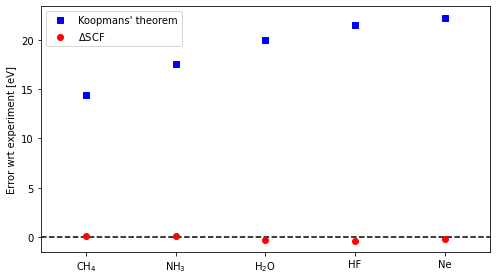

In [3]:
plt.figure(figsize=(7,4))
# Plot error from MO energies and delta-SCF
plt.plot([1,2,3,4,5],err_koopman,'bs')
plt.plot([1,2,3,4,5],err_delta,'ro')
plt.plot([0.5,5.5],[0,0],'k--',zorder=0)

plt.legend(('Koopmans\' theorem',r'$\Delta$SCF'))
plt.ylabel('Error wrt experiment [eV]')
plt.xticks([1,2,3,4,5],(r'CH$_4$',r'NH$_3$',r'H$_2$O','HF','Ne'))
plt.xlim((0.5,5.5))
plt.tight_layout(); plt.show()

We see that the error from orbital energies is large (14.4-22.3 eV) and clearly scale with atomic number, while the error of $\Delta$SCF remains small (absolute error of 0.15-0.38 eV) and does not clearly scale with atomic number. 


### Including for wave-function methods

Considering the X-ray absorption and emission spectrum of water, the error wrt experiment for the ADC hierarchy can be considered as:

In [4]:
# Create pyscf mol object
mol = gto.Mole()
mol.atom  = water_xyz
mol.basis = 'unc-6-31G'
mol.build()

# Perform restricted SCF calculation
scf_gs  = scf.RHF(mol)
scf_gs.kernel()

# Perform CVS-ADC calculations
xas_adc1  = adcc.cvs_adc1(scf_gs,n_singlets=2,core_orbitals=1)
xas_adc2  = adcc.cvs_adc2(scf_gs,n_singlets=2,core_orbitals=1)
xas_adc2x = adcc.cvs_adc2x(scf_gs,n_singlets=2,core_orbitals=1)
xas_adc3  = adcc.cvs_adc3(scf_gs,n_singlets=2,core_orbitals=1)

# Perform unrestricted SCF calculation
scf_gs  = scf.UHF(mol)
scf_gs.kernel()

# Copy molecular orbitals
mo0  = copy.deepcopy(scf_gs.mo_coeff)
occ0 = copy.deepcopy(scf_gs.mo_occ)

# Create 1s core-hole by setting alpha_0 population to zero
occ0[0][0] = 0.0

# Perform unrestricted SCF calculation with MOM constraint
scf_ion = scf.UHF(mol)
scf.addons.mom_occ(scf_ion, mo0, occ0)
scf_ion.kernel()

# Perform ADC calculations
xes_adc1  = adcc.adc1(scf_ion,n_states=2)
xes_adc2  = adcc.adc2(scf_ion,n_states=2)
xes_adc2x = adcc.adc2x(scf_ion,n_states=2)
xes_adc3  = adcc.adc3(scf_ion,n_states=2)

converged SCF energy = -75.9890271783229


/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting cvs-adc1 singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     4       0.10573  119ms  [20.3034032  20.40318715]
  2     8      0.029309  159ms  [20.24463705 20.27156463]
  3    12    0.00022724   97ms  [20.24396663 20.26536094]
=== Converged ===
    Number of matrix applies:    12
    Total solver time:           381.164ms
Starting cvs-adc2 singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     4        2.7182  194ms  [20.32021518 20.4183277 ]
  2     8        0.2748  233ms  [19.73738238 19.85025332]
  3    12     0.0065501  128ms  [19.72453857 19.80831836]
  4    16     0.0011148  166ms  [19.72393684 19.80695317]
  5    20    0.00012468  162ms  [19.72387817 19.80675888]
=== Converged ===
    Number of matrix applies:    20
    Total solver time:           898.095ms
Starting cvs-adc2x singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     4        2.7182  141ms  [20.32021518 20.4183277 ]
  2     8    

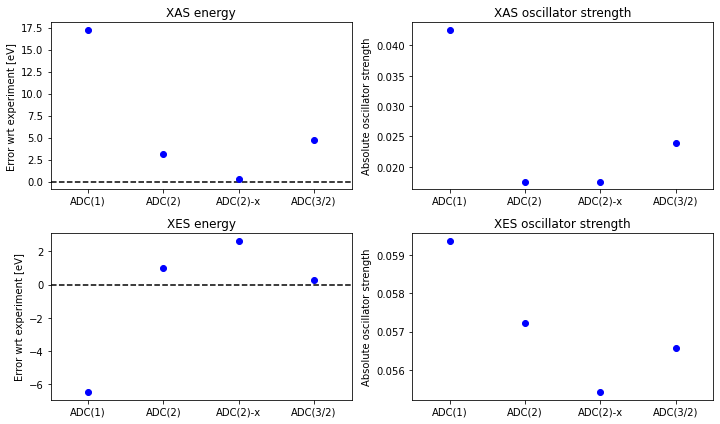

In [5]:
plt.figure(figsize=(10,6))
plt.subplot(221); plt.title('XAS energy')
expt,rel = 534.00,0.37
plt.plot(0, au2ev*xas_adc1.excitation_energy[0]+rel-expt,'bo')
plt.plot(1, au2ev*xas_adc2.excitation_energy[0]+rel-expt,'bo')
plt.plot(2,au2ev*xas_adc2x.excitation_energy[0]+rel-expt,'bo')
plt.plot(3, au2ev*xas_adc3.excitation_energy[0]+rel-expt,'bo')
plt.plot([-0.5,3.5],[0,0],'k--',zorder=0); plt.xlim((-0.5,3.5))
plt.ylabel('Error wrt experiment [eV]')
plt.xticks([0,1,2,3],('ADC(1)','ADC(2)','ADC(2)-x','ADC(3/2)'))

plt.subplot(222); plt.title('XAS oscillator strength')
plt.plot(0, xas_adc1.oscillator_strength[0],'bo')
plt.plot(1, xas_adc2.oscillator_strength[0],'bo')
plt.plot(2,xas_adc2x.oscillator_strength[0],'bo')
plt.plot(3, xas_adc3.oscillator_strength[0],'bo')
plt.xlim((-0.5,3.5))
plt.ylabel('Absolute oscillator strength')
plt.xticks([0,1,2,3],('ADC(1)','ADC(2)','ADC(2)-x','ADC(3/2)'))

plt.subplot(223); plt.title('XES energy')
expt,rel = 527.10,0.37
plt.plot(0, -au2ev*xes_adc1.excitation_energy[0]+rel-expt,'bo')
plt.plot(1, -au2ev*xes_adc2.excitation_energy[0]+rel-expt,'bo')
plt.plot(2,-au2ev*xes_adc2x.excitation_energy[0]+rel-expt,'bo')
plt.plot(3, -au2ev*xes_adc3.excitation_energy[0]+rel-expt,'bo')
plt.plot([-0.5,3.5],[0,0],'k--',zorder=0); plt.xlim((-0.5,3.5))
plt.ylabel('Error wrt experiment [eV]')
plt.xticks([0,1,2,3],('ADC(1)','ADC(2)','ADC(2)-x','ADC(3/2)'))

plt.subplot(224); plt.title('XES oscillator strength')
plt.plot(0, xes_adc1.oscillator_strength[0],'bo')
plt.plot(1, xes_adc2.oscillator_strength[0],'bo')
plt.plot(2,xes_adc2x.oscillator_strength[0],'bo')
plt.plot(3, xes_adc3.oscillator_strength[0],'bo')
plt.xlim((-0.5,3.5))
plt.ylabel('Absolute oscillator strength')
plt.xticks([0,1,2,3],('ADC(1)','ADC(2)','ADC(2)-x','ADC(3/2)'))

plt.tight_layout(); plt.show()

As can be seen, the smallest discrepancy for XAS is observed for CVS-ADC(2)-x, and for XES it is here noted to be for ADC(3/2). In general, it has been noted that CVS-ADC(2)-x performs best for [XAS](), and ADC(2) for [XES](). As ADC(3/2) is correct in higher order of perturbation theory and is [seen]() to perform best for valence excitation, it could be expected to also perform best for core properties. The fact that this is not the case has been [noted]() to be due to balancing in relaxation effects, which are highly influential for core properties and vary significantly between XAS and XES.

Furthermore, we see that the oscullator strengths are varies greatly for XAS $-$ in particular when comparing CVS-ADC(1) to higher order of theory $-$ but not very much for XES.


### Including for DFT-based methods

When using a $\Delta$KS approach, relaxation is explicitly accounted for due to the optimization of the core-hole state. By contrast, TDDFT is a single-excitation theory which cannot properly account for relaxation (which requires doubly-excited configuration in a response theory framework), although it can be partially accounted for through some separate correction scheme. Here it will be counteracted by the self-interaction error, as is discussed [below](sec:xray_topics_sie).



(sec:xray_topics_rel)=
## Relativity

Relativistic effects are siginificantly stronger for core than valence MOs, on account of the strong potential experienced by the core orbitals. These effects mainly influences calculated properties in two separate manners:

1. Scalar relativistic effects, which are always present and lead to a contraction (and thus increase in binding energy) of core orbitals. Higher lying orbitals (especially for $l>1$) can become decontracted due to increasing screening from contracted MOs, but this effect is typically much smaller than for, *e.g.*, 1s

2. Spin-orbit coupling, which breaks degeneracies for MOs of $l>0$ and is thus negligible for, *e.g.*, the $K$- and $L_1$-edges (as the splitting for valence MOs is much smaller), but very important for, *e.g.*, the $L_{2,3}$-edge


### Scalar relativistic effects

Including scalar relativistic effects is relatively straight-forward, as a number of Hamiltonians are available which can include these effects in a 1-component framework. Furthermore, the effects are typically quite stable over the separate elements, and it can thus often be considered as a common absolute off-set in energy. It should be noted that the (scalar) relativistic effects are technically not additive with electron correlation, such that a proper consideration should account for both simultaneously. In practise, this discrepancy is small and relativistc shifts from lower level of theory is typically sufficient.

(sec:xray_topics_rel_ip)=
#### For ionization potentials

The scalar relativistic effects for ionization potentials can be estimated from MO energies or using $\Delta$SCF:

In [6]:
# Containers for atomic number, MO energy shift, delta-SCF shift, and delta-SCF IP
z, mo_diff, delta_diff, delta_ip = [],[],[],[]

# Consider even-numbered elements fron helium to argon
for i in np.arange(2,20,2):
    # Atomic calculation
    struct = str(i)+'   0.0  0.0  0.0'
    # Create pyscf mol object
    mol = gto.Mole()
    mol.atom  = struct
    mol.basis = 'unc-6-31G'
    mol.build()
    # Perform non-relativistic unrestricted SCF calculation
    scf_nr  = scf.UHF(mol)
    scf_nr.kernel()
    # Perform non-relativistic unrestricted SCF calculation
    scf_rel = scf.UHF(mol).x2c1e() # Scalar relativistic effects with the X2C Hamiltonian
    scf_rel.kernel()
    # Append atomic number
    z.append(i)
    # Append MO energy shift
    mo_diff.append(au2ev*(scf_nr.mo_energy[0][0]-scf_rel.mo_energy[0][0]))
    # Copy molecular orbitals and change population of 1s
    mo0  = copy.deepcopy(scf_nr.mo_coeff)
    occ0 = copy.deepcopy(scf_nr.mo_occ)
    occ0[0][0] = 0.0
    # Perform non-relativistic core-hole calculation
    ion_nr  = scf.UHF(mol)
    scf.addons.mom_occ(ion_nr, mo0, occ0)
    ion_nr.kernel()
    # Perform relativistic core-hole calculation (can use the same gues wave function)
    ion_rel = scf.UHF(mol).x2c1e()
    scf.addons.mom_occ(ion_rel, mo0, occ0)
    ion_rel.kernel()
    # Append delta energy and relativistic shift
    delta_diff.append(au2ev*((ion_rel.e_tot-scf_rel.e_tot)-(ion_nr.e_tot-scf_nr.e_tot)))
    delta_ip.append(au2ev*(ion_rel.e_tot-scf_rel.e_tot))

converged SCF energy = -2.85516042615488  <S^2> = -4.4408921e-16  2S+1 = 1
converged SCF energy = -2.85525300824149  <S^2> = -4.4408921e-16  2S+1 = 1
converged SCF energy = -1.99426876611128  <S^2> = 0.75  2S+1 = 2
converged SCF energy = -1.99436899681535  <S^2> = 0.75  2S+1 = 2


Overwritten attributes  get_occ  of <class 'pyscf.x2c.sfx2c1e.sfx2c1e.<locals>.SFX2C1E_SCF'>


converged SCF energy = -14.5695044397229  <S^2> = 4.4408921e-16  2S+1 = 1
converged SCF energy = -14.5720013914685  <S^2> = -1.7763568e-15  2S+1 = 1
converged SCF energy = -10.0436351801509  <S^2> = 0.75848247  2S+1 = 2.0084646
converged SCF energy = -10.0457383213629  <S^2> = 0.75849935  2S+1 = 2.0084814
converged SCF energy = -37.5910403939196  <S^2> = -4.8849813e-15  2S+1 = 1
converged SCF energy = -37.6059227997881  <S^2> = -3.9968029e-15  2S+1 = 1
converged SCF energy = -26.6597884405479  <S^2> = 0.7575222  2S+1 = 2.0075081
converged SCF energy = -26.67113430078  <S^2> = 0.75754084  2S+1 = 2.0075267
converged SCF energy = -74.6585658937069  <S^2> = 1.7763568e-15  2S+1 = 1
converged SCF energy = -74.7104111450883  <S^2> = -1.7763568e-15  2S+1 = 1
converged SCF energy = -54.587706038367  <S^2> = 0.75669834  2S+1 = 2.0066872
converged SCF energy = -54.6258998929871  <S^2> = 0.75671779  2S+1 = 2.0067065
converged SCF energy = -128.47753647693  <S^2> = 2.6645353e-15  2S+1 = 1
converged

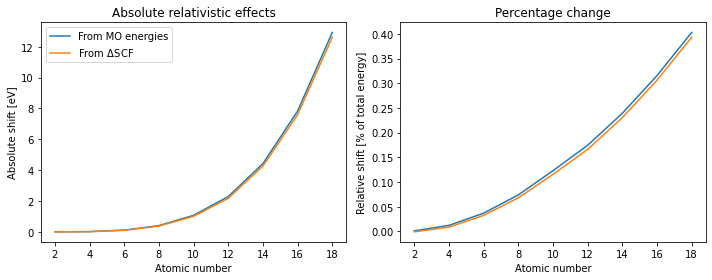

In [9]:
plt.figure(figsize=(10,4))
# Plot absolute scalar relativistic effects
plt.subplot(121); plt.title('Absolute relativistic effects')
plt.plot(z,mo_diff)
plt.plot(z,delta_diff)
plt.xticks(np.arange(2,20,2))
plt.legend(('From MO energies',r'From $\Delta$SCF'))
plt.xlabel('Atomic number')
plt.ylabel('Absolute shift [eV]')

# Plot percentage change
plt.subplot(122); plt.title('Percentage change')
plt.plot(z,100*np.array(mo_diff)/np.array(delta_ip))
plt.plot(z,100*np.array(delta_diff)/np.array(delta_ip))
plt.xticks(np.arange(2,20,2))
plt.xlabel('Atomic number')
plt.ylabel('Relative shift [% of total energy]')
plt.tight_layout(); plt.show()

Two things are immediatelly clear:

1. The shift in 1s ionization potential is strickly non-linear with respect to the atomic number, and using a simple model for a hydrogen-like system the main effects are expected to scale as $Z^4$. Fitting to a power function, we obtain $Z^{4.6}$ (with $R^2=0.997$) for the $\Delta$SCF results, so some deviation from the hydrogenic systems

2. The relativistic shifts for MO energies and $\Delta$SCF IP:s are almost identical, with a discrepancy that increases with $Z$ from 0.00 to 0.31 eV. Performing similar calculations with $\Delta$CCSD is expected to yield very similar values, such that the scalar relativistic effects for the 1s MO of the second and third row can be estimated from MO energies


#### For spectra (XAS)

For spectrum calculations, scalar relativistic effects can be included merely by using an appropriate Hamiltonian for the SCF calculation, as here illustrated for the X-ray absorption spectrum of water:

In [10]:
# Create pyscf mol object
mol = gto.Mole()
mol.atom  = water_xyz
# using a decontracted basis set to better describe contracted relativistic 1s
mol.basis = 'unc-6-31G'
mol.build()

# Perform non-relativistic restricted SCF and CVS-ADC(2) calculations
scf_nr  = scf.RHF(mol)
scf_nr.kernel()
adc_nr  = adcc.cvs_adc2(scf_nr,n_singlets=5,core_orbitals=1)

# Perform relativistic restricted SCF and CVS-ADC(2) calculations
scf_rel = scf.RHF(mol).x2c1e()
scf_rel.kernel()
adc_rel = adcc.cvs_adc2(scf_rel,n_singlets=5,core_orbitals=1)

converged SCF energy = -75.9890271783229
Starting cvs-adc2 singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values


/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


  1    10        2.7777  293ms  [20.27588296 20.31155183 20.86140432 20.92171887 20.92996834]
  2    20      0.035824  522ms  [19.72872545 19.81092766 20.31040554 20.40470691 20.49837544]
  3    30    4.1402e-05  543ms  [19.72388013 19.80673445 20.3057139  20.39997868 20.49772007]
=== Converged ===
    Number of matrix applies:    30
    Total solver time:             1s 385ms
converged SCF energy = -76.0403950942124
Starting cvs-adc2 singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1    10        2.7842  277ms  [20.29049204 20.32651304 20.87612706 20.93658562 20.9451677 ]
  2    20      0.036027  365ms  [19.74278629 19.82524258 20.32473443 20.41889866 20.51251234]
  3    30    4.1677e-05  438ms  [19.73792472 19.82102908 20.32001931 20.41414446 20.51185242]
=== Converged ===
    Number of matrix applies:    30
    Total solver time:             1s 104ms


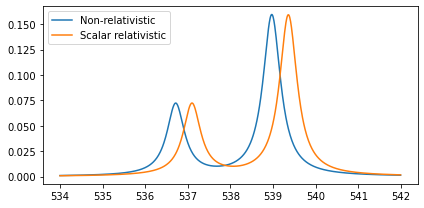

Energy shift of the first feature: 0.38 eV


In [11]:
plt.figure(figsize=(6,3))
# Relativistic and non-relativistc spectra with custom broadening
x,y  = au2ev*adc_nr.excitation_energy, adc_nr.oscillator_strength
xi,yi = lorentzian(x,y,534,542,0.01,0.5); plt.plot(xi,yi)
x,y  = au2ev*adc_rel.excitation_energy, adc_rel.oscillator_strength
xi,yi = lorentzian(x,y,534,542,0.01,0.5); plt.plot(xi,yi)
plt.legend(('Non-relativistic','Scalar relativistic'))
plt.tight_layout(); plt.show()

print('Energy shift of the first feature:',
      np.around(au2ev*(adc_rel.excitation_energy[0]-adc_nr.excitation_energy[0]),2),'eV')

We see that the spectrum is shifted upwards by $\sim$0.38 eV, due to the increase in core-electron binding energy. The same approach can be used for including these effects also for X-ray emission spectrum  calculations.


### Spin-orbit coupling

Including the spin-orbit effects are more complicated, and can either be

- Included by using 4-component relativistic theory, where it does not need to explicitly addressed

- Included in a non-relativistic scheme through a perturbative scheme, or through some *ad hoc* correction 

At the present stage, including spin-orbit effects is beyond the scope of this tutorial. As such, if the $L_{2,3}$edge (or higher-lying edges with $l>0$) is to be considered, the interested reader will have to find this discussion elsewhere.

(sec:xray_topics_basis)=
## Basis set considerations

The basis set requirements of X-ray spectrum calculations depend on which spectroscopy is considered

- XPS and XES probes occupied states, and thus need a good description of those

- XAS and RIXS probes excited states, and thus need an improved description of this region

In all cases the relaxation due to the creation of a core-hole need to be accommodated, which yield requirements of reasonable flexibility of the core and inner valence region. This is not typically the case for standard basis sets, as they are typically constructed with valence properties in mind and thus have a minimal or close to minimal description of the core region. A number of approaches for improving such valence-focused basis sets have thus been developed:

1. Augment the Dunning basis sets with core-polarizing functions, *e.g.* cc-pV*n*Z $\rightarrow$ cc-pCV*n*Z

2. Adding extra flexibility by performing full or partial decontraction, such as
    1. Decontracting 1s of the probed element (*e.g.* u6-311++G\*\*, which is based on 6-311++G\*\*)
    2. Fully decontracting the basis set (*e.g.* un6-311++G\*\*, which is based on 6-311++G\*\*)

3. Use basis functions from the next element, as inspired by the $Z+1$ approximation

As an illustration, we consider the IP of water with different basis sets and levels of theory

*Expand hidden cell for u6-311G\*\*, un6-311G\*\*, and 6-311G\*\* (Z+1) basis sets.*

In [13]:
u6311gss  = {'O': gto.basis.parse('''
O    S
   8588.500                  1.000000 
O    S
   1297.230                  1.000000 
O    S
    299.2960                 1.000000 
O    S
     87.37710                1.000000 
O    S
     25.67890                1.000000 
O    S
      3.740040               1.000000 
O    SP
     42.11750                0.113889               0.0365114
      9.628370               0.920811               0.237153
      2.853320              -0.00327447             0.819702
O    SP
      0.905661               1.000000               1.000000
O    SP
      0.255611               1.000000               1.000000
O    D
      1.292                  1.000000
'''), 'H': '6-311G**'}
un6311gss = {'O': gto.basis.parse('''
O    S
   8588.500                  1.000000 
O    S
   1297.230                  1.000000 
O    S
    299.2960                 1.000000 
O    S
     87.37710                1.000000 
O    S
     25.67890                1.000000 
O    S
      3.740040               1.000000 
O    SP
     42.11750                1.000000               1.000000
O    SP
      9.628370               1.000000               1.000000
O    SP
      2.853320               1.000000               1.000000
O    SP
      0.905661               1.000000               1.000000
O    SP
      0.255611               1.000000               1.000000
O    D
      1.292                  1.000000
'''), 'H': '6-311G**'}
z6311gss  = {'O': gto.basis.parse('''
O    S
   8588.500                  0.00189515
   1297.230                  0.0143859
    299.2960                 0.0707320
     87.37710                0.2400010
     25.67890                0.5947970
      3.740040               0.2808020
O    SP
     42.11750                0.113889               0.0365114
      9.628370               0.920811               0.237153
      2.853320              -0.00327447             0.819702
O    SP
      0.905661               1.000000               1.000000
O    SP
      0.255611               1.000000               1.000000
O    D
      1.292                  1.000000
O    S
  11427.10                   0.00180093
   1722.350                  0.0137419
    395.7460                 0.0681334
    115.1390                 0.2333250
     33.60260                0.5890860
      4.919010               0.2995050
O    SP
     55.44410                0.114536               0.0354609
     12.63230                0.920512               0.237451
      3.717560              -0.00337804             0.820458
O    SP
      1.165450               1.000000               1.000000
O    SP
      0.321892               1.000000               1.000000
O    D
      1.750                  1.000000
'''), 'H': '6-311G**'}

```python
# Investigated basis sets
basis_sets = ['6-311G**',u6311gss,un6311gss,z6311gss, 'cc-pVDZ', 'cc-pCVDZ', 'cc-pVTZ', 'cc-pCVTZ','cc-pVQZ', 'cc-pCVQZ']

# Containers for IP calculated with four different delta calculations: HF, MP2, CCSD, and B3LYP
ip_hf, ip_mp2, ip_ccsd, ip_b3lyp, n_bas = [],[],[],[],[]

for basis in basis_sets:
    # Create pyscf mol object
    mol = gto.Mole()
    mol.atom  = water_xyz
    mol.basis = basis
    mol.build()
    # Unrestricted SCF calculation of neutral
    scfres = scf.UHF(mol)
    scfres.kernel()
    # Copy molecular orbitals and change population of 1s
    mo0 = copy.deepcopy(scfres.mo_coeff)
    occ0 = copy.deepcopy(scfres.mo_occ)
    occ0[0][0] = 0.0
    # Unrestricted HF calculation of core-hole and appending delta_HF IP
    scfion = scf.UHF(mol)
    scf.addons.mom_occ(scfion, mo0, occ0)
    scfion.kernel()
    ip_hf.append(au2ev*(scfion.energy_tot() - scfres.energy_tot()))
    # CCSD calculations of neutral and core-hole and appending delta_CCSD IP
    ccsd_res = cc.UCCSD(scfres).run()
    ccsd_ion = cc.UCCSD(scfion).run(max_cycle=500)
    ip_ccsd.append(au2ev*(ccsd_ion.e_tot - ccsd_res.e_tot))
    # Appending delta_MP2 IP
    ip_mp2.append(au2ev*(ccsd_ion.e_hf+ccsd_ion.emp2-(ccsd_res.e_hf+ccsd_res.emp2)))
    # Unrestricted KS-DFT calculation of neutral
    scfres = scf.UKS(mol)
    scfres.xc = 'b3lyp'
    scfres.kernel()
    # Copy molecular orbitals and change population of 1s
    mo0 = copy.deepcopy(scfres.mo_coeff)
    occ0 = copy.deepcopy(scfres.mo_occ)
    occ0[0][0] = 0.0
    # Unrestricted KS-DFT calculation of core-hole and appending delta_DFT IP
    scfion = scf.UKS(mol)
    scf.addons.mom_occ(scfion, mo0, occ0)
    scfion.xc = 'b3lyp'; scfion.kernel()
    ip_b3lyp.append(au2ev*(scfion.energy_tot() - scfres.energy_tot()))
    # Append basis set size
    n_bas.append(len(scfres.mo_occ[0]))
    
plt.figure(figsize=(10,5))
# Plot IP:s, with error as a function of basis set size
plt.plot(n_bas,ip_hf,'r*')
plt.plot(n_bas,ip_mp2,'bv')
plt.plot(n_bas,ip_ccsd,'d',color='orange')
plt.plot(n_bas,ip_b3lyp,'go')
plt.legend(('HF','MP2','CCSD','B3LYP','Expt','Expt - 0.37 eV'))

# Experimental value as a dotted line, minus relativistic effect as dashed line
plt.plot([min(n_bas)-5,max(n_bas)+5],[539.9,539.9],'k:')
plt.plot([min(n_bas)-5,max(n_bas)+5],[539.9-0.37,539.9-0.37],'k--')

# Basis set label as x-ticks
basis_set_labels = ['6-311G**','u6-311G**','un6-311G**','6-311G** (Z+1)', 'cc-pVDZ', 'cc-pCVDZ', 'cc-pVTZ', 'cc-pCVTZ','cc-pVQZ', 'cc-pCVQZ']
plt.xticks(n_bas,basis_set_labels,rotation=70,fontsize=10)

# Labels and setting x-interval
plt.ylabel('Ionization potential [eV]')
plt.xlim((min(n_bas)-5,max(n_bas)+5))
plt.tight_layout(); plt.show()
```

The execution of which yields


```{figure} ../img/xray/basis_xps.svg
---
name: basis_xps
---
```

At the HF and KS-DFT levels of theory we see that some of the smaller basis sets have fortuitous error cancellations, such that both 6-311G\*\* and cc-pVTZ yields results close to experimental values. However, augmenting these basis sets with more functions in the core region brings us away from experimental measurements (note that the calculations does not include relativistic effects, so the comparison would be toward experiment minus relativistic shift, *i.e.* the dashed line).

With MP2 and CCSD we note very similar results for the smaller basis sets, which then deviates significantly for cc-pVTZ and above. $\Delta$CCSD estimates using core-polarized cc-pVTZ and cc-pVQZ are well in line with experimental measurements. Augmenting 6-311G\*\* basis sets with decontracted core region (u6-311G\*\*) yields some improvement at a relatively low increase in computational cost, and further decontracting the full set (un6-311G\*\*) or adding basis functions from $Z+1$ (6-311G\*\* (Z+1)) yields some additional improvement.


(sec:xray_topics_sie)=
## Self-interaction error in DFT

For a single-electron systems the following equality should hold for the two-electron terms:

\begin{equation}
J[\rho] + E_{xc} [\rho] = 0.0
\end{equation}

This cancellation is preserved within HF theory, but for any approximate functionals in KS-DFT the equality will no longer hold, resulting in the potentially significant errors due to spurious self-interactions. Reformulated, the Coulomb self-repulsion of each electron included in the Coulomb operator is exactly canceled by the nonlocal exchange self-attraction in Hartree-Fock, but this is no longer the case when the exchange operator is replaced by an approximate exchange functional.

As such, KS-DFT possess a self-interaction error (SIE), which shows a strong dependence on how compact the respective MOs are. This means that the self-interaction error is significantly more influential for core properties than for valence properties, and the tendency to decontract core orbitals due to the SIE has a opposite effect on transition energies as compared to relaxation effects.

Let us consider the ionization potential of water, as calculated with MO energy and $\Delta\textrm{SCF}$ using two different exchange-correlation functionals with variable HF exchange: 

```{note}
Using MO energies for TDHF and TDDFT yield the same IP as when addressing core-transition to extremely diffuse basis functions (due to the lack of relaxation), and is thus representative of the error for such XAS calculations.
```

In [4]:
# Create pyscf mol object
mol       = gto.Mole()
mol.atom  = water_xyz
mol.basis = '6-31G'
mol.build()

# Investigated HF exchange and result containers
hf_exc  = [0.0,0.25,0.50,0.75,1.0]
hf_blyp,hf_pbe = [[],[]], [[],[]]

def dft_delta(mol,xc):
    # Neutral calculation
    dft_res    = scf.UKS(mol)
    dft_res.xc = xc
    dft_res.kernel()
    # Core-hole calculation
    mo0  = copy.deepcopy(dft_res.mo_coeff)
    occ0 = copy.deepcopy(dft_res.mo_occ)
    occ0[0][0] = 0.0
    dft_ion = scf.UKS(mol)
    dft_ion.xc = xc
    scf.addons.mom_occ(dft_ion, mo0, occ0)
    dft_ion.kernel()
    return -au2ev*dft_res.mo_energy[0][0],au2ev*(dft_ion.energy_tot() - dft_res.energy_tot())

for h_x in hf_exc:
    # BxLYP (Slater exchange 0.08, except when HF i 1.00)
    if h_x == 1.0: s_x = 0.00
    else:          s_x = 0.08 
    b_x      = 1.00 - h_x - s_x
    v_e, v_l = 0.19, 0.81
    xc       = f'{h_x:} * HF + {s_x:} * Slater + {b_x:} * B88, {v_l:} * LYP + {v_e:} * VWN'
    E_mo, E_delta = dft_delta(mol,xc)
    hf_blyp[0].append(E_mo)
    hf_blyp[1].append(E_delta)
    # PBEx
    p_x = 1.0 - h_x
    xc  = f'{h_x:} * HF + {p_x:} * PBE, PBE'
    E_mo, E_delta = dft_delta(mol,xc)
    hf_pbe[0].append(E_mo)
    hf_pbe[1].append(E_delta)

converged SCF energy = -76.3570352138422  <S^2> = 9.9031894e-13  2S+1 = 1


Overwritten attributes  get_occ  of <class 'pyscf.dft.uks.UKS'>


converged SCF energy = -56.4237670553342  <S^2> = 0.75372494  2S+1 = 2.0037215
converged SCF energy = -76.2984404502067  <S^2> = 6.8922645e-13  2S+1 = 1
converged SCF energy = -56.3921764305246  <S^2> = 0.75419443  2S+1 = 2.00419
converged SCF energy = -76.3458605029087  <S^2> = 1.9792168e-11  2S+1 = 1
converged SCF energy = -56.4097695592283  <S^2> = 0.75459735  2S+1 = 2.0045921
converged SCF energy = -76.3012084721052  <S^2> = 3.3262282e-12  2S+1 = 1
converged SCF energy = -56.3896010586894  <S^2> = 0.7552122  2S+1 = 2.0052054
converged SCF energy = -76.3352647255065  <S^2> = 1.3764101e-11  2S+1 = 1
converged SCF energy = -56.3960927713704  <S^2> = 0.7556359  2S+1 = 2.005628
converged SCF energy = -76.304577252447  <S^2> = 2.934275e-11  2S+1 = 1
converged SCF energy = -56.3873473076527  <S^2> = 0.75643162  2S+1 = 2.0064213
converged SCF energy = -76.325199834941  <S^2> = 1.0940582e-11  2S+1 = 1
converged SCF energy = -56.3826985529724  <S^2> = 0.75686154  2S+1 = 2.0068498
converged S

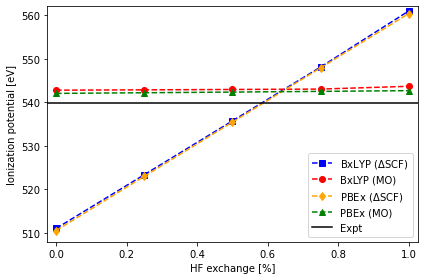

In [7]:
plt.figure(figsize=(6,4))
# DFT ionization potentials, including scalar relativistic shift
plt.plot(hf_exc,np.array(hf_blyp[0])+0.37,'bs--')
plt.plot(hf_exc,np.array(hf_blyp[1])+0.37,'ro--')
plt.plot(hf_exc,np.array(hf_pbe[0])+0.37,'d--',color='orange')
plt.plot(hf_exc,np.array(hf_pbe[1])+0.37,'g^--')

# Experimental value and legend
plt.plot([-0.1,1.1],[539.9,539.9],'k-')
plt.legend((r'BxLYP ($\Delta$SCF)','BxLYP (MO)',r'PBEx ($\Delta$SCF)','PBEx (MO)','Expt'))

plt.xlim((-0.025,1.025)); plt.ylim((508,562.))
plt.xlabel('HF exchange [%]')
plt.ylabel('Ionization potential [eV]')
plt.tight_layout(); plt.show()

We see that the $\Delta$SCF error is quite constant between the two base functionals and amounts of HF exchange, while the MO energies strongly scale with HF exchange, but not the base functional. The total MO error is a function of two effects:

1. Lack of relaxation, which generally leads to an overestimation of IP:s and core-excitation energies

2. Self-interaction, which by contrast leads to an underestimation of these energies

For a typical exchange-correlation functiona ($\sim$20-25% HF exchange) the SIE thus dominates, and by tuning the (global) HF exchange to around 60% we achieve IP estimates in good agreement to experiment. We note that this is only acheieved by cancellation of above two errors, and does not mean that we have an appropriate description (or any description) of the core-excitation processes. Furthermore, a good exchange-correlation functional should possess good energies *and* densities, and focusing on only energies can push us away from such a goal. Nevertheless, a number of tailored functionals with good absolute energies have been constructed, tuning the HF exchange either in a global or range-separated manner. Note that the parameterization will have to depend on the spectroscopy, probed edge, and row of the periodic table, as the exact balance in relaxation terms and SIE varies.


```{note}
Could add radial distribution/densities of functionals and compare to HF, and maybe explicitly calculate the SIE/above inequality.
```

(sec:xray_topics_chloc)=
## Core-hole localization

For $\Delta$ SCF calculations (either for estimating IP:s or as a initial state for XES) a core-hole is created at some atomic site. For many systems, this is unproblematic, but if chemically equivalent atoms are present, the MOs are delocalized over these sites. Pefrorming a straightforward $\Delta$SCF calculation will then results in a delocalized core-hole, as illustrated below for ethene:

In [2]:
ethene_xyz = '''
C0      0.6660048050     0.0000000000    -0.0000000000
C1     -0.6660048050    -0.0000000000     0.0000000000
H       1.2278735620     0.9228358077    -0.0000000000
H       1.2278735620    -0.9228358077    -0.0000000000
H      -1.2278735620     0.9228358077     0.0000000000
H      -1.2278735620    -0.9228358077     0.0000000000
'''

# All-electron calculation of IP
delta_all = Koopman_vs_delta(ethene_xyz, 'unc-6-31G')

# IP calculation with ECP on one carbon
delta_ecp = Koopman_vs_delta(ethene_xyz, 'unc-6-31G', {'C0':'stuttgart'})

NameError: name 'Koopman_vs_delta' is not defined

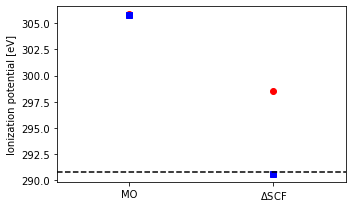

In [33]:
plt.figure(figsize=(5,3))
# IP estimates with all-electron (delocalized core-hole)
plt.plot([1,2],[delta_all[0]+0.11,delta_all[1]+0.11],'ro')

# IP estimates with ECP (localized core-hole)
plt.plot([1,2],[delta_ecp[0]+0.11,delta_ecp[1]+0.11],'bs')

# Experiment and figure settings
plt.plot([0.5,2.5],[290.80,290.80],'k--')
plt.ylabel('Ionization potential [eV]')
plt.xticks([1,2],('MO',r'$\Delta$SCF'))
plt.xlim((0.5,2.5))
plt.tight_layout(); plt.show()

As can be seen, the error from MO energies are very similar for the all-electron calculation (with a delocalized core-hole) and using ECP (delocalized core-hole). For the $\Delta$SCF calculation, however, only approximately half the relaxation energy is accounted for using a delocalized core-hole. Such a discrepancy for delocalized calculations of IP:s have been noted in previously, and it has been associated with missing correlation effects which are required to properly correct the delocalized calculation. Within a full CI scheme, delocalization will no longer be an issue (and it will capture the small shift in energy between the gerade and ungerade core-hole).

Moving from theory, in experiment the localizatio/delocalization of core-holes is primarily relevant for diatomic systems, as other compounds will possess vibrational effects which breaks the symmetry. For diatomic systems the localized/delocalized nature of the core-hole has been seen to depend on the details of the measurement, such that both can be probed {cite}`ref`.

As such, for practical calculation we recommend that core-holes are localized for IP and XES calculations. For XAS it does not provide any issues for linear response methods (provided that both gerade and ungerade MOs are kept in the CVS space/equivalent), but for state-specific approaches this will again be an issue (*e.g.* STEX and TP-DFT).


(sec:xray_topics_tailcvs)=
## Tailored CVS


For large systems, it may become relevant to tailor the CVS space such that each chemically unique atom is probed in turn. While this the requires explicit consideration of each set of unique MOs in turn, it serves dual purposes which can make it worth it:

1. It lower the dimensionality of the involved matrices, and thus decrease computational costs

2. The density-of-states decrease, which means that the same energy region can be resolved with a few states per unique MO, rather than having to converge a large number of eigenstates simultaneously


While this technically does not fulfill one of foundations on which the CVS approximation is built (the MOs are not energetically well-separated), the spatial separation means that it will typically work. As an example, we consider ethene (which has delocalized MO:s) and vinylfluoride (which does not):

In [21]:
vinyl_xyz = """
 C     0.000000    -0.246412    -1.271068
 C     0.000000     0.457081    -0.154735
 F     0.000000    -0.119195     1.052878
 H     0.000000     0.272328    -2.210194
 H     0.000000    -1.319906    -1.249847
 H     0.000000     1.530323    -0.095954
"""

print('Ethene')
# Create pyscf mol object
mol       = gto.Mole()
mol.atom  = ethene_xyz
mol.basis = '6-31G'
mol.build()
# Perform restricted SCF calculation
scf_gs  = scf.RHF(mol)
scf_gs.kernel()
# Perform CVS-ADC calculations
ethene_adc1_0  = adcc.cvs_adc1(scf_gs,n_singlets=4,core_orbitals=[0])
ethene_adc1_1  = adcc.cvs_adc1(scf_gs,n_singlets=4,core_orbitals=[1])
ethene_adc1_01 = adcc.cvs_adc1(scf_gs,n_singlets=4,core_orbitals=[0,1])
ethene_adc2_0  = adcc.cvs_adc2(scf_gs,n_singlets=4,core_orbitals=[0])
ethene_adc2_1  = adcc.cvs_adc2(scf_gs,n_singlets=4,core_orbitals=[1])
ethene_adc2_01 = adcc.cvs_adc2(scf_gs,n_singlets=4,core_orbitals=[0,1])

print('Vinylfluoride')
# Create pyscf mol object
mol       = gto.Mole()
mol.atom  = vinyl_xyz
mol.basis = '6-31G'
mol.build()
# Perform restricted SCF calculation
scf_gs  = scf.RHF(mol)
scf_gs.kernel()
# Perform CVS-ADC calculations
vinyl_adc1_1  = adcc.cvs_adc1(scf_gs,n_singlets=4,core_orbitals=[1])
vinyl_adc1_2  = adcc.cvs_adc1(scf_gs,n_singlets=4,core_orbitals=[2])
vinyl_adc1_12 = adcc.cvs_adc1(scf_gs,n_singlets=4,core_orbitals=[0,1,2])
vinyl_adc2_1  = adcc.cvs_adc2(scf_gs,n_singlets=4,core_orbitals=[1])
vinyl_adc2_2  = adcc.cvs_adc2(scf_gs,n_singlets=4,core_orbitals=[2])
vinyl_adc2_12 = adcc.cvs_adc2(scf_gs,n_singlets=4,core_orbitals=[0,1,2])

For ethene
converged SCF energy = -78.0041367697306


/home/thomas/pkg/adcc/adcc/backends/__init__.py:48: UserWarning: Could not check host program psi4 minimal version, since __version__ tag not found. Proceeding anyway.
  "".format(module)


Starting cvs-adc1 singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8       0.03528  272ms  [10.9407699  11.18596003 11.18814426 11.23216937]
  2    15    0.00017832  225ms  [10.88951159 11.162916   11.17172328 11.21366663]
=== Converged ===
    Number of matrix applies:    15
    Total solver time:           512.348ms
Starting cvs-adc1 singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8      0.035017  136ms  [10.93953818 11.18405836 11.18618601 11.23055868]
  2    15    0.00018157  122ms  [10.888685   11.1607163  11.16972747 11.21203137]
=== Converged ===
    Number of matrix applies:    15
    Total solver time:           266.526ms
Starting cvs-adc1 singlet Jacobi-Davidson ...
Niter n_ss  max_residual  time  Ritz values
  1     8      0.047214  396ms  [10.93953818 10.9407699  11.12926169 11.12999659]
  2    16     0.0016423  209ms  [10.84929754 10.84932523 11.07667553 11.07801415]
  3    24    0.00024386  168ms  [10.84786316

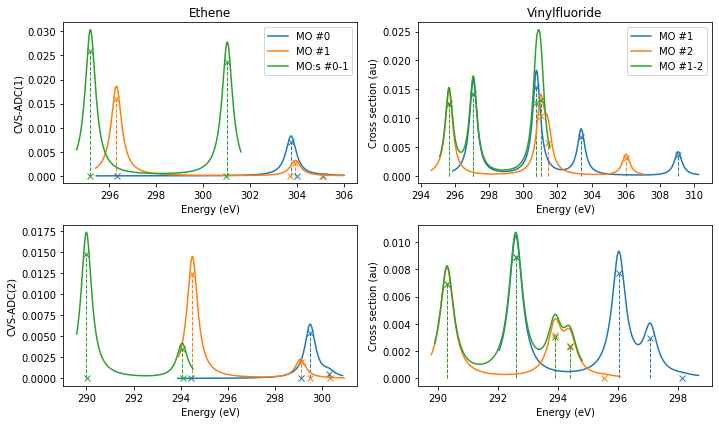

In [22]:
plt.figure(figsize=(10,6))
# Ethene with CVS-ADC(1)
plt.subplot(221); plt.title('Ethene')
ethene_adc1_0.plot_spectrum(label='MO #0')
ethene_adc1_1.plot_spectrum(label='MO #1')
ethene_adc1_01.plot_spectrum(label='MO:s #0-1')
plt.legend()
plt.ylabel('CVS-ADC(1)')

# Vinylfluoride with CVS-ADC(1)
plt.subplot(222); plt.title('Vinylfluoride')
vinyl_adc1_1.plot_spectrum(label='MO #1')
vinyl_adc1_2.plot_spectrum(label='MO #2')
vinyl_adc1_12.plot_spectrum(label='MO #1-2')
plt.legend()

# Ethene with CVS-ADC(2)
plt.subplot(223)
ethene_adc2_0.plot_spectrum()
ethene_adc2_1.plot_spectrum()
ethene_adc2_01.plot_spectrum()
plt.ylabel('CVS-ADC(2)')

# Vinylfluoride with CVS-ADC(2)
plt.subplot(224)
vinyl_adc2_1.plot_spectrum()
vinyl_adc2_2.plot_spectrum()
vinyl_adc2_12.plot_spectrum()

plt.tight_layout(); plt.show()

We see that considering each MO in turn works well for vinylfluoride, where the two carbon 1s are localized, but not for ethene, where they are delocalized. Including or not including fluorine here makes little difference, as that MO is both energetically and spatially well separated from the carbon 1s.

Note that the delocalization might not be immediatelly apparent, as just visually looking at the molecule and concluding which atoms are unique might not be sufficient. Care should be taken for larger systems, and explicitly looking at the MOs is adviced. Alternatively, using ECP:s to localize the core-hole and then restricting the CVS space accordingly will avoid this issue.
    
    

(sec:xray_cons_spur_val)=
## Spurious valence mixing in XAS

Within a damped response theory framwork or when performing explicit real-time propagation, a CVS-like scheme which separates core-transitions from the valence-continuum is usually not performed. If such calculations are run with a atom-centered basis set (as most are), this can then lead to spurious mixing with valence-excited states. What happens is that resonances in the valence-continuum occur close to core-excitations, leading to unphysical mixing which affects excitation energies and (more significantly) intensities. These issues occur both for methods featuring only single-excited configurations (*e.g.* TDDFT) and higher-excited configurations (*e.g.* ADC) and need to be avoided.

The issue has been observed for, *e.g.*, $L_{2,3}$-edge of silicon {cite}`xas4crttddft, ledge2016`, and is usually more common at lower energies. They can be identified by studying the amplitudes and the $t^2$ values for post-HF methods, and can be avoided by chosing appropriate basis set, freezing certain virtual orbitals, or by re-introducing the CVS approximation (or some other flavour) within the CPP/RT framework. The latter is noted to be recommended in any case for CPP-ADC, as converging the response vectors has otherwise been seen to be difficult {cite}`gator`.